# Flowers classification using Transfer Learning with fine tuning

## Importing the main libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import tensorflow as tf
from   tensorflow import keras

import os
from google.colab import drive
drive.mount('/content/drive' , force_remount=True )

Mounted at /content/drive


## Loading the Images Dataset

In [3]:
data = pd.read_csv ('/content/drive/MyDrive/computer vision course/All Flowers classification projects/Flowers classification DNN/all_data.csv' , names = ['Images Path' , 'Label'])

In [4]:
data.head()

Images Path  Label
0  gs://cloud-ml-data/img/flower_photos/daisy/100...  daisy
1  gs://cloud-ml-data/img/flower_photos/daisy/101...  daisy
2  gs://cloud-ml-data/img/flower_photos/daisy/101...  daisy
3  gs://cloud-ml-data/img/flower_photos/daisy/101...  daisy
4  gs://cloud-ml-data/img/flower_photos/daisy/101...  daisy

## EDA

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3670 entries, 0 to 3669
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Images Path  3670 non-null   object
 1   Label        3670 non-null   object
dtypes: object(2)
memory usage: 57.5+ KB


In [6]:
data['Label'].value_counts()

Label
dandelion     898
tulips        799
sunflowers    699
roses         641
daisy         633
Name: count, dtype: int64

In [7]:
data.isna().sum()

Images Path    0
Label          0
dtype: int64

In [8]:
px.histogram ( data , x = 'Label')

## Images Preprocessing

### Defining the images' Dimensions and labels

In [9]:
Img_Width  = 224
Img_Height = 224
Img_Channels = 3    # RGB

Labels =  [ 'daisy' , 'roses' , 'sunflowers' , 'tulips' , 'dandelion' ]

### Reading the Images then Decoding it

In [10]:
def read_decode ( image , resizeDimensions ) :
  image = tf.io.read_file ( image )
  image = tf.image.decode_jpeg ( image , channels = Img_Channels )
  image = tf.cast ( image , tf.float32 ) # changed the pixels' data types to float( 255 -> 255.0 ) , no scaling here -> we will scale at the base mode [range from -1 to 1 ]
  image = tf.image.resize ( image , resizeDimensions )
  return image

### Reading the csv file

In [11]:
ImagesLocalPath = "/content/drive/MyDrive/computer vision course/All Flowers classification projects/Flowers classification DNN/Flowers"

def read_csv ( csv_line ) :
  csvDataTypes = ["" , ""]

  cloud_path , labelName = tf.io.decode_csv ( csv_line , csvDataTypes )
  CloudPathParts = tf.strings.split(cloud_path, '/')
  category = CloudPathParts[-2]                         # Folder name (daisy)
  filename = CloudPathParts[-1]                         # Image name  (123.jpg)

  # building the new path which Colab can read the images from
  local_path = tf.strings.join([ImagesLocalPath , '/' ,  category, '/', filename])

  image = read_decode ( local_path , [Img_Width, Img_Height] )
  labelNumber = tf.argmax   (tf.math.equal ( Labels , labelName ) )
  return image , labelNumber

### Defining The Dataset

In [12]:
Train_dataset = (
    tf.data.TextLineDataset('/content/drive/MyDrive/computer vision course/All Flowers classification projects/Flowers classification DNN/train_set.csv')
    .map( read_csv , num_parallel_calls = tf.data.AUTOTUNE )
    .shuffle(3300)
    .repeat()
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

Evaluation_dataset = (
    tf.data.TextLineDataset('/content/drive/MyDrive/computer vision course/All Flowers classification projects/Flowers classification DNN/eval_set.csv')
    .map( read_csv , num_parallel_calls = tf.data.AUTOTUNE )
    .shuffle(370)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

## showing the results

In [13]:
for imageBatch , labelBatch in Train_dataset.take(1):
  print(imageBatch.shape)
  print(labelBatch.shape)

(32, 224, 224, 3)
(32,)


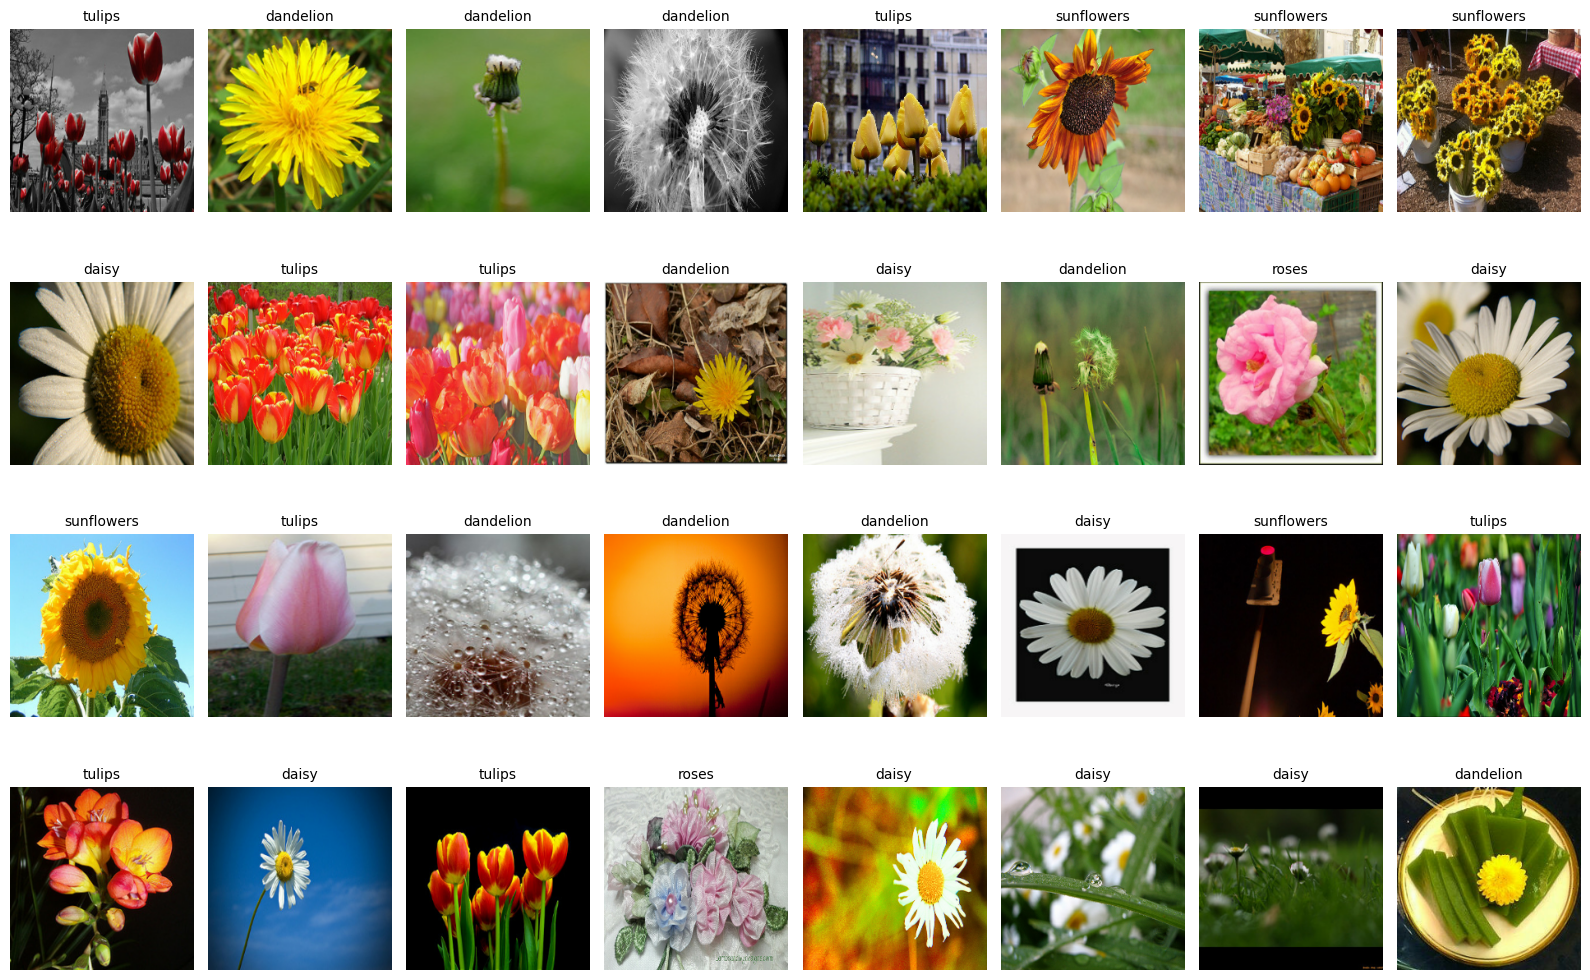

In [14]:
plt.figure(figsize=(16, 10.5))
for i, (image, true_label) in enumerate(zip(imageBatch, labelBatch)):
    if i >= 32:  # Limit to 32 images for display, assuming batch size 32
        break
    plt.subplot(4, 8, i + 1)
    # The images are already in a [0, 255] range float format based on previous warnings, convert to uint8 for display.
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"{Labels[true_label.numpy()]}", fontsize= 10)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Model Initializing and Training Phase

### Adding the base model ( Mobile Net V2 )

In [15]:
base_model = keras.applications.MobileNetV2 (
    input_shape = (Img_Width , Img_Height , Img_Channels) ,
    include_top = False ,
    weights = 'imagenet'
)

base_model.trainable = True    # Default

### Model Initialization

In [16]:
model = keras.Sequential ()

In [17]:
# No faltten layer as the MobileNetV2 model expecting a tensors images as an input because it totally depends on CNN with use kernals to scan the tensors

# Input Layer
model.add( keras.Input(shape=(Img_Width, Img_Height, Img_Channels)))

# preprocessing
model.add(keras.layers.Lambda(
    keras.applications.mobilenet_v2.preprocess_input  # scale my images to ranged from [ -1 : 1 ] as the images that MobileNetV2 model was trained on .
))
# add base model
model.add ( base_model )
model.add ( keras.layers.GlobalAveragePooling2D() )

model.add (keras.layers.Dense(128, use_bias=False))
model.add ( keras.layers.BatchNormalization() )
model.add ( keras.layers.Activation('relu') )
model.add ( keras.layers.Dropout ( 0.5 ) )

model.add ( keras.layers.Dense ( 5 , activation = 'softmax' ) )

### Model compiling

In [18]:
model.compile(
    optimizer = keras.optimizers.Adam( learning_rate= 0.00001) ,
    loss      = keras.losses.SparseCategoricalCrossentropy(),
    metrics   = ['accuracy']
)

### Model Training

In [19]:
EPOCHS = 35
TrainingSize = 3300
ValidationSize  = 370
Batch_size   = 32
steps_per_epoch  =   TrainingSize  // Batch_size     # 3300 // 32 = 103 steps ( 3296 image )


early_stop = keras.callbacks.EarlyStopping(
    monitor  ='val_loss',
    patience = 3 ,                # لو مفيش تحسن لمدة 3 دورات، وقّف
    restore_best_weights = True   # رجع لي أحسن أوزان وصل لها الموديل
)


history = model.fit(
    Train_dataset ,
    steps_per_epoch  = steps_per_epoch ,
    validation_data  = Evaluation_dataset ,
    #initial_epoch    = 30 ,
    epochs = EPOCHS ,
    callbacks = [early_stop]
)

Epoch 1/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.3027 - loss: 1.8246

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



103/103 ━━━━━━━━━━━━━━━━━━━━ 117s 345ms/step - accuracy: 0.3033 - loss: 1.8229 - val_accuracy: 0.4541 - val_loss: 1.3370
Epoch 2/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.5330 - loss: 1.1690 - val_accuracy: 0.5784 - val_loss: 1.0560
Epoch 3/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.6622 - loss: 0.8927 - val_accuracy: 0.6568 - val_loss: 0.8595
Epoch 4/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.7581 - loss: 0.7055 - val_accuracy: 0.7270 - val_loss: 0.7214
Epoch 5/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - accuracy: 0.7974 - loss: 0.6011 - val_accuracy: 0.7919 - val_loss: 0.6108
Epoch 6/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.8264 - loss: 0.5179 - val_accuracy: 0.8162 - val_loss: 0.5338
Epoch 7/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.8427 - loss: 0.4580 - val_accuracy: 0.8324 - val_loss: 0.4836
Epoch 8/35
103/103 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - accuracy: 0.8611 - loss: 0.4166 - va

In [20]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Model Loss', 'Model Accuracy'))

# Add traces for loss
fig.add_trace(go.Scatter(y=history.history['loss'],
                         mode='lines',
                         name='Train Loss',
                         marker_color='blue'),
              row=1, col=1)
fig.add_trace(go.Scatter(y=history.history['val_loss'],
                         mode='lines',
                         name='Validation Loss',
                         marker_color='red'),
              row=1, col=1)

# Add traces for accuracy
fig.add_trace(go.Scatter(y=history.history['accuracy'],
                         mode='lines',
                         name='Train Accuracy',
                         marker_color='blue'),
              row=1, col=2)
fig.add_trace(go.Scatter(y=history.history['val_accuracy'],
                         mode='lines',
                         name='Validation Accuracy',
                         marker_color='red'),
              row=1, col=2)

# Update layout for better readability
fig.update_layout(height=550, width=1350, title_text="Model Training History")
fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=1)
fig.update_xaxes(title_text="Epoch", row=1, col=2)
fig.update_yaxes(title_text="Accuracy", row=1, col=2)

fig.show()

## Model Evaluation with the Best Final version - Validation

In [27]:
results = model.evaluate(Evaluation_dataset)

print( f"Final Validation Loss: {results[0]:.2f}" )
print( f"Final Validation Accuracy: {results[1]:.2f}" )

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8971 - loss: 0.3245
Final Validation Loss: 0.26
Final Validation Accuracy: 0.91


## Model Evaluation - Predicting

In [28]:
for imageBatch_eval, labelBatch_eval in Evaluation_dataset.take(1):
    print("Shape of image batch from evaluation dataset:", imageBatch_eval.shape)
    print("Shape of label batch from evaluation dataset:", labelBatch_eval.shape)

Shape of image batch from evaluation dataset: (32, 224, 224, 3)
Shape of label batch from evaluation dataset: (32,)


In [29]:
predictions   = model.predict(imageBatch_eval)
probabilities = tf.nn.softmax(predictions)
predicted_labels = tf.argmax(probabilities, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


In [24]:
#print ( predictions  , '\n' )
#print ( probabilities, '\n' )
#print ( predicted_labels    )


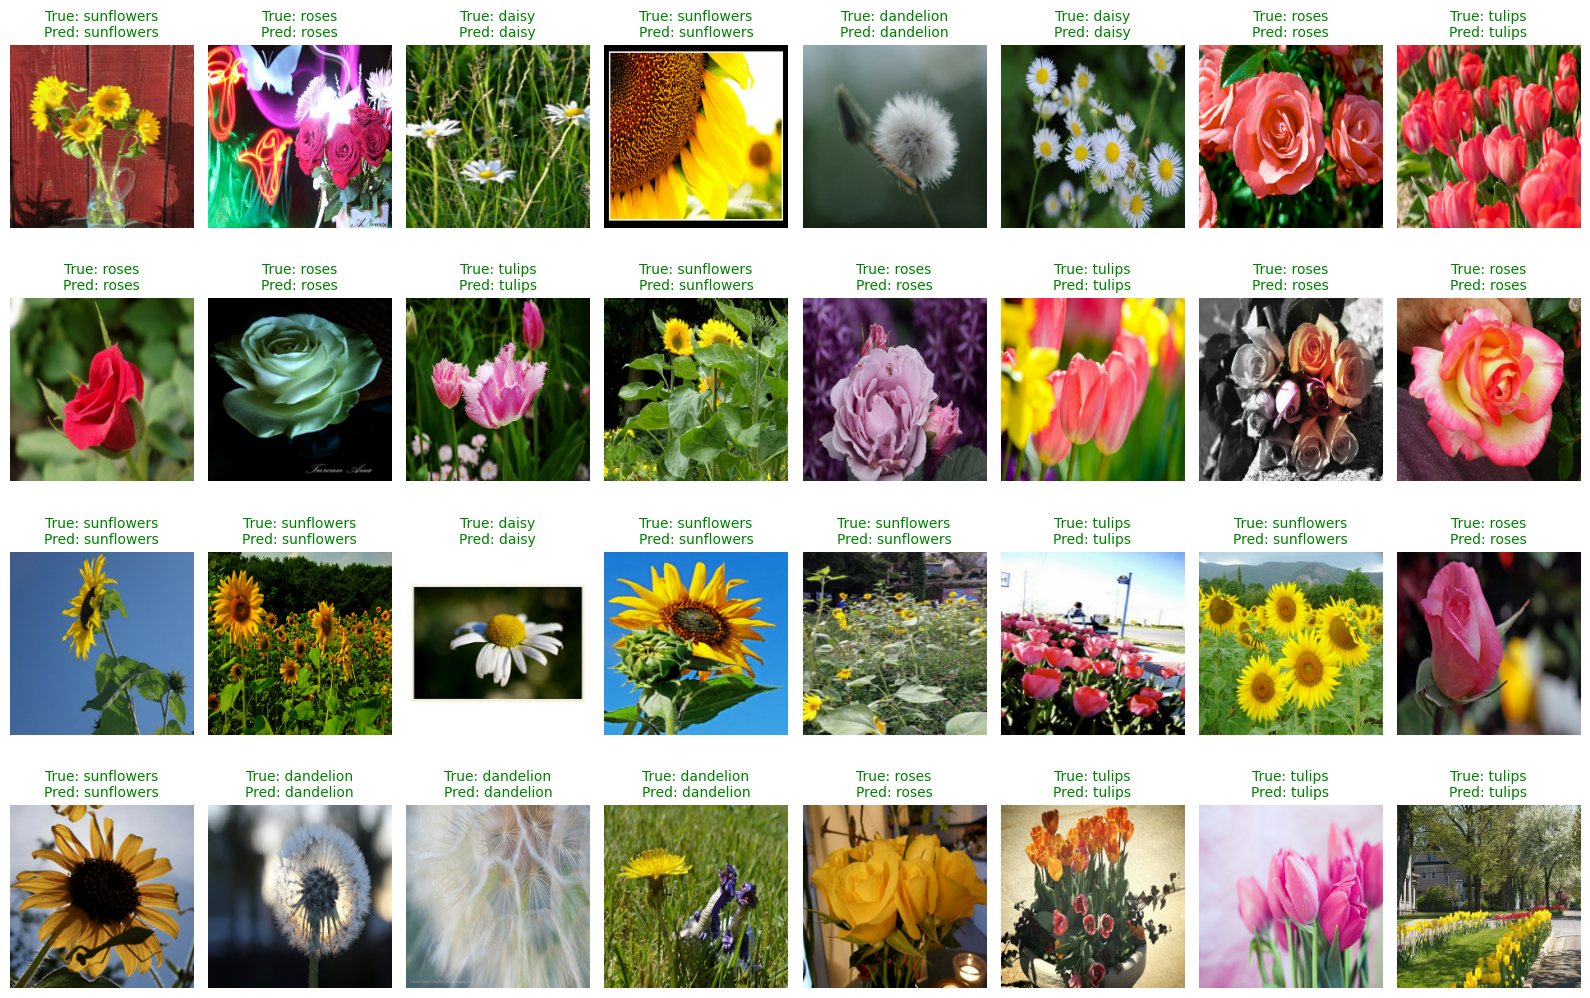

In [30]:
plt.figure(figsize=(16, 10.5))
for i, (image, true_label, predicted_label) in enumerate(zip(imageBatch_eval, labelBatch_eval, predicted_labels)):
    if i >= 32:  # Limit to 32 images for display
        break
    plt.subplot(4, 8, i + 1)
    # Convert image to uint8 for proper display as it's currently float32 from decoding and resizing
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"True: {Labels[true_label.numpy()]}\nPred: {Labels[predicted_label.numpy()]}", fontsize= 10 , color='green' if true_label.numpy() == predicted_label.numpy() else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()